# 1.5 Scikit-learn

[Scikit.learn](http://scikit-learn.org/stable/) is Python's main machine learning library for small- to medium-data.  It's very mature and implements almost every well-known machine learning algorithm.  It's useful for prototyping and testing solutions at a small scale before expanding to your whole dataset.  The Spark equivalent, `MLLib`, is growing more mature every day, but is not yet at the level of `scikit-learn`. 

**WARNING:** The examples here are necessarily very brief!  Jake Vanderplas has a much more in-depth [tutorial on scikit.learn](https://github.com/jakevdp/sklearn_tutorial).  Many examples taken from there

**WARNING 2:** `Scikit-learn` is _vast_ and I haven't used it very often in my own work.  So for many questions, I'll do my best, but I might have to look things up and get back to you.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn import datasets, linear_model

# Optional: importing this package makes the default plot settings nicer
import seaborn as sns; sns.set()

## Linear regression

To explore linear regression, let's generate some noisy data that tracks a line:

In [2]:
def linear_data_sample(N=40, rseed=0, m=3, b=-2):
    """Sample N points on the line y = m*x + b + err, where err is normally distributed"""
    rng = np.random.RandomState(rseed)

    x = 10 * rng.rand(N)
    y = m * x + b + 1.5*rng.randn(N)

    return x, y

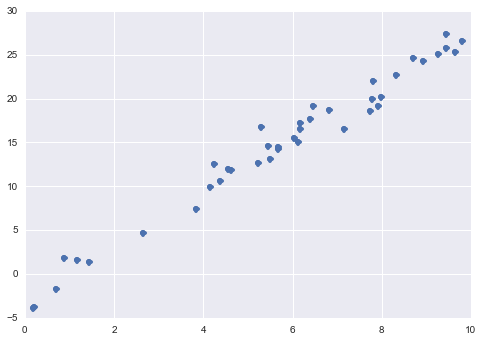

In [3]:
x, y = linear_data_sample()
plt.plot(x, y, 'o');

We saw earlier how to implement least-square regression "the pedestrian way": explicitly specifying a loss function that we that we then ask SciPy to minimize.

In [4]:
# Least-squares linear Regression, the pedestrian way
def model(theta, x):
    b, m = theta
    return m * x + b

def square_deviation(theta, x, y):
    return np.sum((model(theta, x) - y) ** 2)

from scipy.optimize import fmin
theta_guess = [0, 1]
theta_fit = fmin(square_deviation, theta_guess, args=(x, y))

b_fit, m_fit = theta_fit
print 'Actual: m = 3, b = -2'
print 'Fit: m = %.2f, b = %.2f' % (m_fit, b_fit)

Optimization terminated successfully.
         Current function value: 67.545975
         Iterations: 76
         Function evaluations: 144
Actual: m = 3, b = -2
Fit: m = 3.04, b = -2.76


Of course, `scikit-learn` has linear regression built in, with a simple interface.

In [5]:
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x.reshape((len(x), 1)), y)   # Scikit-learn expects x to be a column-vector

print 'Actual: m = 3, b = -2'
print 'Fit: m = %.2f, b = %.2f' % (regr.coef_[0], regr.intercept_)

Actual: m = 3, b = -2
Fit: m = 3.04, b = -2.76


Many `scikit-learn` models are packaged as "predictors".  Once you've trained/fit a model, you can use it to predict outputs for given inputs.  Let's use that to plot the line of best fit.

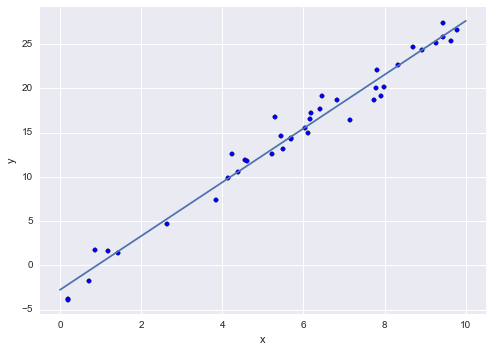

In [6]:
# predict y from the data
x_new = np.linspace(0, 10, 100)
y_new = regr.predict(x_new.reshape((len(x_new), 1)))  # Column vector

# plot the results
ax = plt.axes()
ax.scatter(x, y)
ax.plot(x_new, y_new)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.axis('tight');

**Ex 1.5.1: What's the equation of the line of best fit?**

**Ex 1.5.2: What's the predicted value of `y` for `x = 2.5`?**

## Classification

Support vector machines (SVMs) are one common way of classifying data points as belonging to one of two classes.

To gain some experience with it, let's generate some random data that's clearly clustered.  `scikit-learn` has plenty of ways of generating random datasets with some structure.  Let's use `make_blobs` to generate 50 points in 2D drawn from two Gaussian distributions with different (random) centers.

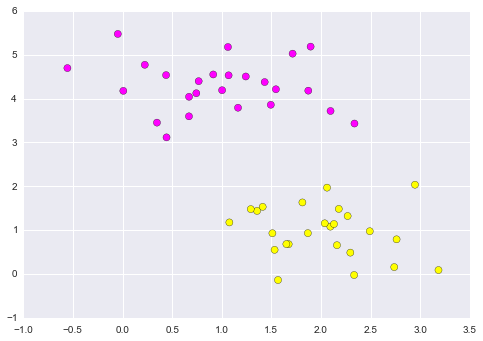

In [7]:
# SVMs
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

That's what the data looks like on a plot.  It's always useful to see a bit of your data up close:

In [8]:
print X[:10]
print y[:10]

[[ 1.41281595  1.5303347 ]
 [ 1.81336135  1.6311307 ]
 [ 1.43289271  4.37679234]
 [ 1.87271752  4.18069237]
 [ 2.09517785  1.0791468 ]
 [ 2.73890793  0.15676817]
 [ 3.18515794  0.08900822]
 [ 2.06156753  1.96918596]
 [ 2.03835818  1.15466278]
 [-0.04749204  5.47425256]]
[1 1 0 0 1 1 1 1 1 0]


Like linear regression, SVMs are implemented as "predictors": you create a model object, call its `fit` function on your data, then call `predict` to make new predictions

In [9]:
from sklearn.svm import SVC # "Support Vector Classifier"
model = SVC(kernel='linear')
model.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

It turns out that, for this dataset, the classifier is pretty much perfect:

In [10]:
print(y[:30])
print(model.predict(X)[:30])

[1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0]
[1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0]


Jake Vanderplas' has put together a nice way of visualizing the decision surface for this SVM, which makes it clear why the model does well:

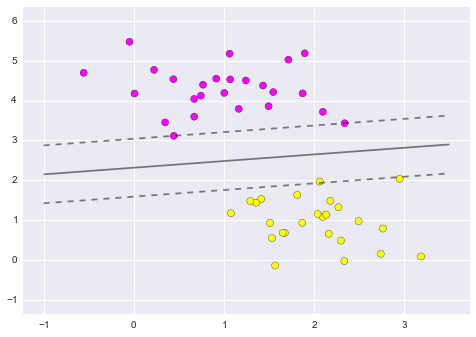

In [11]:
def plot_svc_decision_function(model, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    
    ## This is the key loop!
    ## model.decision_function calculates the distance from a given point
    ## to the decision hyperplane.  "0" is the decision hyperplane,
    ## and "+/- 1" are the two boundaries of the "margin zone"
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = model.decision_function([xi, yj])
    
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1],  # Decision hyperplanes and boundaries of margin zone
                      alpha=0.5,
                      linestyles=['--', '-', '--'])



plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(model);

**Ex 1.5.3.  What is the predicted class for a point at (1.5, 2.0)?**

## Dimensionality Reduction (PCA)

Frequently, data that's encoded with high-dimensional features actually lies close to a low-dimensional hyperplane.  Principal Components Analysis is a standard way of finding such low-dimensional representations of your data, which may be useful for explanations, as well as for reducing computational costs.

As usual, let's simulate random data in 2D that's really almost in 1D:

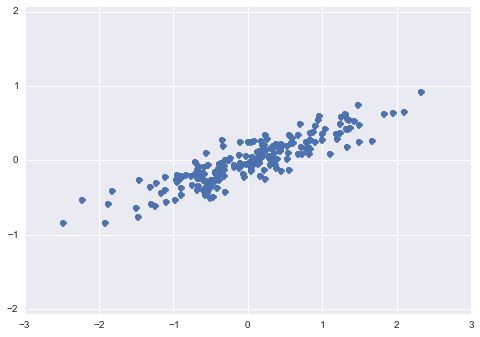

In [12]:
# Two-dimensional data set that's almost 1D
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], 'o')
plt.axis('equal');

In [13]:
# Apply PCA with two components to this data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_)
print(pca.components_)

[ 0.75871884  0.01838551]
[[ 0.94446029  0.32862557]
 [ 0.32862557 -0.94446029]]


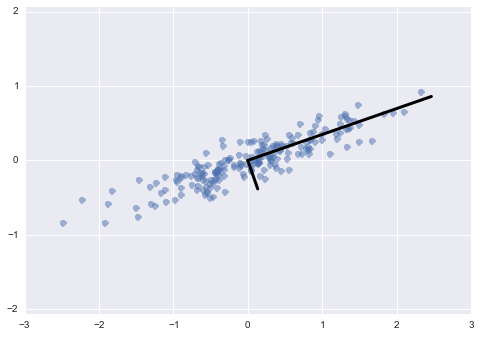

In [14]:
# Visualize components
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

Once we've found the two principal components, we can reduce the dimensionality of the data from 2D to 1D by projecting it onto the larger principal component. 

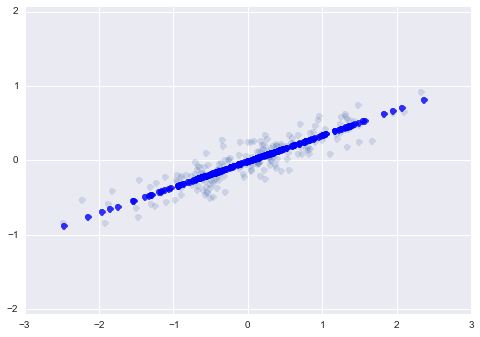

In [15]:
# PCA with 1 component
model = PCA(n_components=1)
X_trans = model.fit_transform(X)          # Project onto principal directions
X_new = model.inverse_transform(X_trans)  # Return to unprojected space
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

## K-means

$k$-means is the simplest and most standard algorithm for discovering clusters in high-dimensional data.

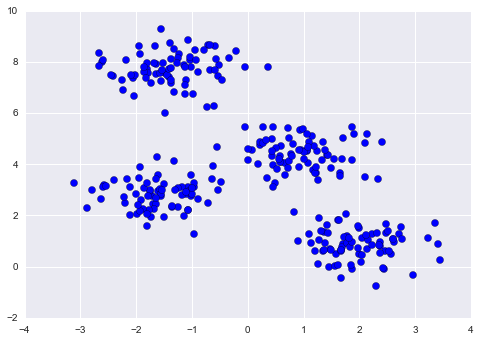

In [16]:
# Make fake clustered data
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

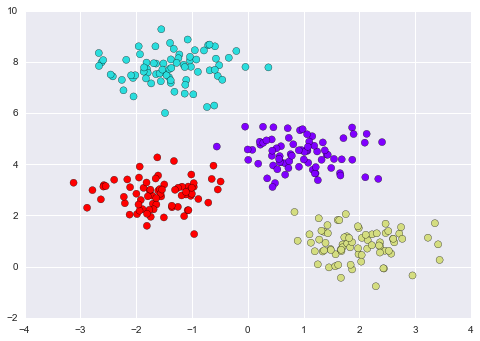

In [17]:
# Cluster into 4 clusters using K-means
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

**(!) Ex 1.5.4. Make a plot that visualizes the result of the above classifier everywhere in the x-y plane.**